In [182]:
import h5py    
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from IPython.display import clear_output
import multiprocessing as mp
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
# figsize(10,8)



In [183]:
import h5py as h5
l1 = h5.File('./data/CFIS_L1_NGDCS20170619t184335_cal_2018_v2.h5','r')
spectra_ = np.array(l1['camera/radiances'][:])
wlSize=2048
disp = np.asarray([-1.2553e-6,0.0201,735.4572])
ind = np.linspace(1,wlSize,wlSize)
wlGrid_ = np.polyval(disp,ind )
wlGrid = wlGrid_[(wlGrid_>747)&(wlGrid_<756)]
spectra_ = spectra_[:,(wlGrid_>747)&(wlGrid_<756),:]
l1.close()



In [184]:
# Read in tabulated pre-computed dataset.
sun = np.loadtxt('data/solar_merged_20160127_600_26316_100.out')
# interpolate to common grid in wavelength (not wavenumber), use 0.002nm sampling here
res = 0.002
# create wavelength grid in nm
wl = np.arange(500,1000,res)
# Solar transmission spectrum, resample to wavelength grid (from wavenumber):
f = interp1d(1.e7/sun[:,0], sun[:,1])
Tsun = f(wl)
co = 2.355
T_cfis = gaussian_filter1d(Tsun, 0.07/res/co)




In [185]:
f1 = h5py.File('./data/PS_SIF_map_easy.h5','r')    
f1_keys=list(f1.keys())
list(f1.keys())
SIF_shape_ = f1['SIF_shape'][:] # (437,)

wl_sif = f1['wlGrid'][:] # dwlGrid = 0.03 (437,)
f = interp1d(wl_sif,SIF_shape_,fill_value="extrapolate")
SIF_shape = f(wl)
f1.close()

In [186]:
spectra = np.mean(spectra_[100,:,500:600],axis=-1)
print(spectra_.shape)

(256, 501, 1432)


In [187]:
co = 2.355

class Setup:
    pass
mySetup = Setup()

mySetup.FWHM = 0.07
# wo = np.where((wl_solarSpectrum>743)&(wl_solarSpectrum<757))[0]
# mySetup.wl_so = wl

mySetup.wl_in = wl
mySetup.wl_out = wlGrid
mySetup.res = 0.01 # wlGrid[1:]-wlGrid[0:-1]




In [188]:
# reference solar spectrum
# Lo = Tsun*s_base/np.pi # mW/M2/SR/UM
Tsun = T_cfis.copy()
Lo = Tsun/np.pi 

In [189]:

def forward_model_shift(x,b):
    poly_wl = x[0:3]
    poly = x[-4:-1]
    a = x[-1]
#     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    
    F_sif = Lo+a*SIF_shape
    dwl = b.wl_in-np.mean(b.wl_in)
    F_poly = F_sif*np.polyval(poly,dwl)
    
    
    detPixels = len(b.wl_in)
    grid = np.arange(0,detPixels,1)-detPixels/2.
#     wl_shifted = grid+c1 # b.nu_out in the example 8
    wl_shifted = np.polyval(poly_wl,grid)
    
    finter1 = interp1d(grid, F_poly,kind='linear', fill_value=np.NaN,bounds_error=False)
    F_shifted = finter1(wl_shifted)
    F_conv_shifted = gaussian_filter1d(F_shifted,b.FWHM/b.res/co)

    finter2 = interp1d(b.wl_in, F_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
    F_forward = finter2(b.wl_out)# output Lo
    return F_forward
  
def compK(x,b):
    dx = [1e-6,1e-6,1e-6,1e-6,1e-6,1e-6,1e-6]
    K = np.zeros((len(b.wl_out),len(x)))
    for i in range(len(x)):
        x2 = x.copy()
        x2[i] = x[i]+dx[i]
        FF = forward_model_shift(x2,b)
        F = forward_model_shift(x,b)
        K[:,i] = (FF-F)/dx[i]
    return K
        

def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
    chi2_r_old = 1e9
    DOF = len(F)-len(x0)
    invSe = noise_model(F)
    F0_guess = forward_model_shift(x0,b)
    K = compK(x0,b)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x = x0+ Gain.dot(F-F0_guess)
    F0 = forward_model_shift(x,b)
    K = compK(x,b)
    chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
    chi2_r = chi2/DOF
    
    chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
    for i in range(n_itr):
        
        
        #F0,K = forward_model_shift(x,b,compK=True)
        Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
        x_plus1 = x+ Gain.dot(F-F0)
        S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
        sif_1sigma = np.sqrt(S_posterior[-1,-1])
        #F2 = forward_model_shift(x_plus1,b)
        F2= forward_model_shift(x_plus1,b)
        K_new = compK(x_plus1,b)
        chi2 = np.sum((F2-F)**2*np.diag(invSe))
        chi2_r = chi2/DOF
        chi2_r_itr.append(chi2_r)
        x_linear_itr.append(x_plus1)
        sif_1sigma_itr.append(sif_1sigma)
        if abs(chi2_r-chi2_r_old) < thrs:
            print('iteration %d' %i)
            break
        else:
            x = x_plus1.copy() 
            chi2_r_old = chi2_r.copy()
            F0 = F2.copy()
            K = K_new.copy()
            
        
    return x_linear_itr,sif_1sigma_itr,chi2_r_itr



def noise_model(F):
# '''This is the noise model for each point on the map'''
# '''F is the measured radiance, which is a function of wavelength'''
    
    invSe = np.zeros((len(F),len(F)))
    
    noise = np.sqrt(F)/40
    
    invSe=np.diag(1./(noise**2) )
    return invSe


def linear_fit(F):
    invSe = noise_model(F)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x_linear = Gain.dot(F)
    S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
    sif_1sigma = np.sqrt(S_posterior[-1,-1])
    chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
    chi2_r = chi2/(len(F)-len(x_linear))
    return x_linear,sif_1sigma,chi2_r

In [190]:
F_forward= forward_model_shift([0,1,40]+[0.132,-0.25,233.1,0],mySetup)
K = compK([0,1,40]+[0.132,-0.25,233.1,0],mySetup)

x_linear,sif_1sigma,chi2_r = linear_fit(spectra)


In [191]:
K

array([[ 7.88422377e+03, -4.40670755e+00,  3.28986971e-03, ...,
        -9.20700742e-01,  3.16446460e-01,  2.56020684e+02],
       [ 1.49953897e+04, -9.44749162e+00,  6.64249455e-03, ...,
        -9.15443536e-01,  3.16664028e-01,  2.55868119e+02],
       [ 1.50633386e+04, -1.06043662e+01,  7.02746661e-03, ...,
        -9.10441130e-01,  3.16972745e-01,  2.55715696e+02],
       ...,
       [ 2.46265086e+05,  8.54622474e+01,  2.86710105e-02, ...,
         1.89494425e+00,  3.13599017e-01,  1.88255568e+02],
       [ 1.90540279e+05,  7.57653110e+01,  2.53465231e-02, ...,
         1.90637182e+00,  3.14586984e-01,  1.88152079e+02],
       [ 6.76411668e+04,  4.61848508e+01,  1.54092135e-02, ...,
         1.91643349e+00,  3.15344764e-01,  1.88048644e+02]])

In [192]:
x_linear

array([ 5.81603915e-07, -1.61010913e-03, -9.63344049e+00,  1.22366032e-01,
        5.03811443e-01,  2.14991174e+02,  2.40940963e-02])

In [193]:
chi2_r

1.7433938605055341

Text(0.5,1,'linear retrievel one step')

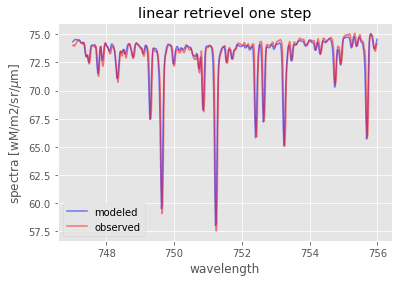

In [194]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

In [195]:
np.mean(wlGrid)

751.5550797906333

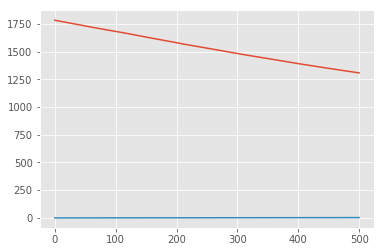

In [196]:
plt.plot((K[:,6]-1)*7)
plt.plot(K[:,4])

Text(0.5,1,'F_forward-F_observed')

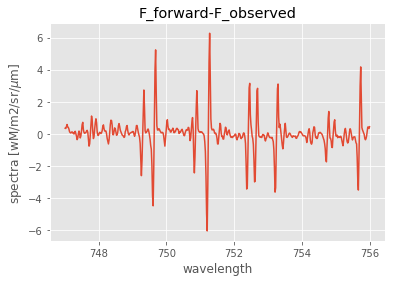

In [144]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [145]:
ma,mb,mc = iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)

iteration 79


In [146]:
len(ma)

80

In [147]:
np.array(ma)[:,-1]

array([-0.01440384, -0.01123736, -0.01137964, -0.01144989, -0.01144299,
       -0.01144453, -0.01144381, -0.01144405, -0.01144397, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144399, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01144398,
       -0.01144398, -0.01144398, -0.01144398, -0.01144398, -0.01

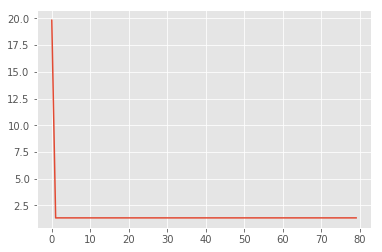

In [148]:
plt.plot(mc)

In [149]:
ma

[array([ 1.15592327e-07,  9.99212851e-01,  3.06339047e+01,  1.15699816e-01,
        -2.42112167e-01,  2.40930662e+02, -1.44038417e-02]),
 array([ 1.69051265e-08,  9.99518441e-01,  3.05360041e+01,  1.15870641e-01,
        -3.51938616e-01,  2.41702968e+02, -1.12373621e-02]),
 array([-1.46095802e-08,  9.99595727e-01,  3.05296540e+01,  1.15794403e-01,
        -3.54227122e-01,  2.41808821e+02, -1.13796374e-02]),
 array([-1.16002973e-08,  9.99586446e-01,  3.05304090e+01,  1.15773567e-01,
        -3.56122847e-01,  2.41865422e+02, -1.14498938e-02]),
 array([-1.21087424e-08,  9.99587643e-01,  3.05311412e+01,  1.15775447e-01,
        -3.55937110e-01,  2.41859876e+02, -1.14429894e-02]),
 array([-1.18286942e-08,  9.99586996e-01,  3.05309021e+01,  1.15774963e-01,
        -3.55978989e-01,  2.41861120e+02, -1.14445320e-02]),
 array([-1.19210747e-08,  9.99587233e-01,  3.05309367e+01,  1.15775173e-01,
        -3.55959293e-01,  2.41860536e+02, -1.14438071e-02]),
 array([-1.18881281e-08,  9.99587123e-01,

In [151]:
F_forward= forward_model_shift(np.array(ma)[-1,:],mySetup)

Text(0.5,1,'non-linear retrievel last step')

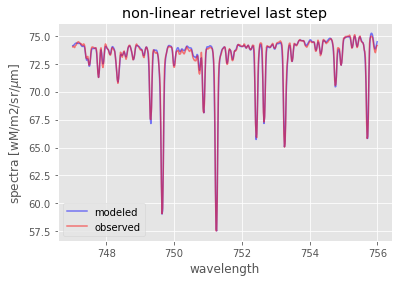

In [154]:

plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

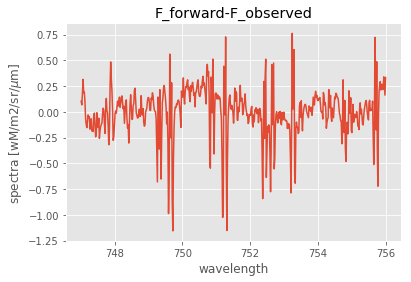

In [155]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [157]:
spectra2 =spectra_[220,:,550]
F_forward= forward_model_shift([0,1,40]+[0.132,0.38,233.1,0],mySetup)
x_linear,sif_1sigma,chi2_r = linear_fit(spectra2)


Text(0.5,1,'non-linear retrievel last step')

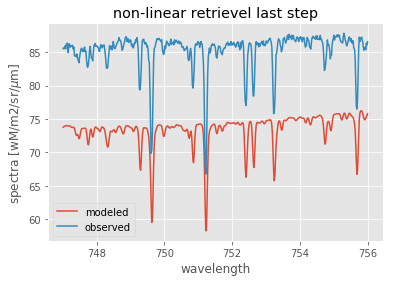

In [158]:
plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

In [160]:

ma,mb,mc =iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra2,n_itr=200,thrs=1e-6)

In [161]:
F_forward= forward_model_shift(np.array(ma)[-1,:],mySetup)
K = compK(np.array(ma)[-1,:],mySetup)

In [162]:
ma

[array([-6.62818097e-08,  9.98942553e-01,  4.64756560e+01,  2.44443446e-02,
         1.28752533e-01,  2.77743494e+02, -6.36489200e-03]),
 array([-6.85669480e-08,  9.98939319e-01,  4.66178066e+01,  2.43259995e-02,
         1.02227111e-01,  2.78334696e+02, -6.72269842e-03]),
 array([-4.88434494e-08,  9.98885084e-01,  4.66139797e+01,  2.43186678e-02,
         1.00791016e-01,  2.78376573e+02, -6.76776140e-03]),
 array([-3.72401182e-08,  9.98850147e-01,  4.66283810e+01,  2.43370167e-02,
         1.01178978e-01,  2.78361702e+02, -6.75134025e-03]),
 array([-3.73774957e-08,  9.98853852e-01,  4.66220454e+01,  2.43441418e-02,
         1.01773033e-01,  2.78343145e+02, -6.73097794e-03]),
 array([-3.72251263e-08,  9.98852329e-01,  4.66243851e+01,  2.43447483e-02,
         1.01763597e-01,  2.78343320e+02, -6.73116445e-03]),
 array([-3.75114192e-08,  9.98853773e-01,  4.66228858e+01,  2.43443680e-02,
         1.01783100e-01,  2.78342811e+02, -6.73060843e-03]),
 array([-3.73945531e-08,  9.98853050e-01,

In [163]:
np.array(ma)[:,-1]

array([-0.00636489, -0.0067227 , -0.00676776, -0.00675134, -0.00673098,
       -0.00673116, -0.00673061, -0.0067312 , -0.00673088, -0.00673118,
       -0.00673087, -0.00673119, -0.00673087, -0.00673119, -0.00673087,
       -0.00673118, -0.00673087, -0.00673118, -0.00673087, -0.00673119,
       -0.00673087, -0.00673118, -0.00673087, -0.00673118, -0.00673087,
       -0.00673119, -0.00673087, -0.00673119, -0.00673087, -0.00673119,
       -0.00673087, -0.00673118, -0.00673087, -0.00673118, -0.00673087,
       -0.00673118, -0.00673087, -0.00673119, -0.00673087, -0.00673118,
       -0.00673087, -0.00673118, -0.00673087, -0.00673118, -0.00673087,
       -0.00673119, -0.00673087, -0.00673119, -0.00673087, -0.00673118,
       -0.00673087, -0.00673118, -0.00673087, -0.00673118, -0.00673087,
       -0.00673118, -0.00673087, -0.00673119, -0.00673086, -0.00673118,
       -0.00673087, -0.00673119, -0.00673087, -0.00673118, -0.00673087,
       -0.00673118, -0.00673087, -0.00673118, -0.00673087, -0.00

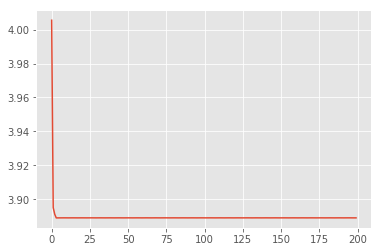

In [164]:
plt.plot(mc)

Text(0.5,1,'spectra 2 non-linear retrievel last step')

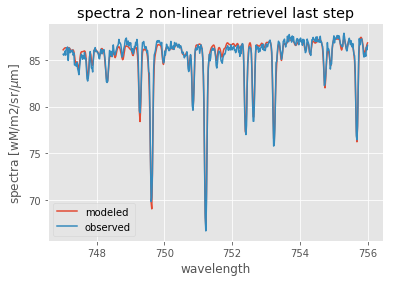

In [165]:

plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 non-linear retrievel last step')

Text(0.5,1,'spectra 2 F_forward-F_observed')

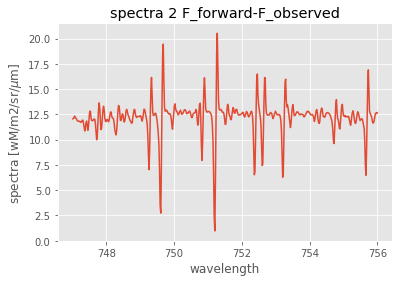

In [166]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 F_forward-F_observed')

In [167]:
np.array(ma)[:,-1]

array([-0.00636489, -0.0067227 , -0.00676776, -0.00675134, -0.00673098,
       -0.00673116, -0.00673061, -0.0067312 , -0.00673088, -0.00673118,
       -0.00673087, -0.00673119, -0.00673087, -0.00673119, -0.00673087,
       -0.00673118, -0.00673087, -0.00673118, -0.00673087, -0.00673119,
       -0.00673087, -0.00673118, -0.00673087, -0.00673118, -0.00673087,
       -0.00673119, -0.00673087, -0.00673119, -0.00673087, -0.00673119,
       -0.00673087, -0.00673118, -0.00673087, -0.00673118, -0.00673087,
       -0.00673118, -0.00673087, -0.00673119, -0.00673087, -0.00673118,
       -0.00673087, -0.00673118, -0.00673087, -0.00673118, -0.00673087,
       -0.00673119, -0.00673087, -0.00673119, -0.00673087, -0.00673118,
       -0.00673087, -0.00673118, -0.00673087, -0.00673118, -0.00673087,
       -0.00673118, -0.00673087, -0.00673119, -0.00673086, -0.00673118,
       -0.00673087, -0.00673119, -0.00673087, -0.00673118, -0.00673087,
       -0.00673118, -0.00673087, -0.00673118, -0.00673087, -0.00

In [168]:
spectra_.shape

(256, 501, 1432)

In [169]:

SIF = []; SIF_1SIGMA = [];CHI2_R = []
for i in range(100,102):
    for j in range(10,20):
        spectra = spectra_[i,:,j]
        ma,mb,mc =iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-4)
        SIF.append(ma[-1][-1])
        SIF_1SIGMA.append(mb[-1])
        CHI2_R.append(mc[-1])
        

iteration 6
iteration 4
iteration 7
iteration 4
iteration 5
iteration 6
iteration 6
iteration 5
iteration 7
iteration 6
iteration 4
iteration 6
iteration 5
iteration 5
iteration 4
iteration 5
iteration 4
iteration 4


In [170]:
SIF = np.reshape(np.array(SIF),(2,10))

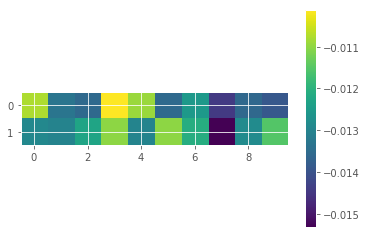

In [171]:
plt.imshow(np.array(SIF))
plt.colorbar()

In [1245]:
SIF

array([[-3.56173738, -4.08393654, -4.87719827, -2.97753397, -3.2970219 ,
        -4.16211039, -4.28041544, -4.49176341, -4.28504129, -4.58051271],
       [-4.97995712, -3.98620439, -4.01655917, -3.23399441, -3.90082967,
        -3.20638275, -3.95050982, -4.85823439, -3.97430978, -3.76581071]])